# One Qubit PER
In [Extending quantum probabilistic error cancellation through noise scaling](https://arxiv.org/abs/2108.02237) by Mari et. Al, a method of transforming a QPD representation of gates to produce a noise-scaled gate is set forth. This notebook uses `mitiq` to implement this method for general QPD representations and carries it out on a measurement of $Z$ after the circuit $X\ket{0}$.

In [91]:
#helper libraries
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from random import random

#operator info
from qiskit.quantum_info import Pauli, SuperOp, Kraus, Operator, pauli_basis
from qiskit import QuantumCircuit, Aer, execute 
from qiskit.providers.aer.noise import kraus_error, NoiseModel

#Mitiq
from mitiq.pec.types import OperationRepresentation, NoisyOperation
from mitiq.pec import execute_with_pec

plt.style.use("ggplot")

## Create noise model

This method works for general Pauli channels, but the sparse noise model described in van den Berg et Al. is used here for better comparison to the other notebooks.

This next cell defines the model parameters

In [95]:
n = 1 #number of qubits
F = pauli_basis(1, pauli_list = True) #list of paulis
T = [Pauli("X"), Pauli("Y"), Pauli("Z")] #These are the terms considered in the model
coeffs = [.1*random() for p in T] #These are the corresponding lambdas
omegas = np.multiply(.5, np.add(1, np.exp(np.multiply(-2.0, coeffs)))) #Equation (S9)

The following cell leverages the product form of this error model $\Lambda(\cdot) = \prod_{k \in \mathcal{T}}\omega_k\mathcal{I}(\cdot)+(1-\omega_k)\mathcal{P}_k(\cdot)$ to generate a superoperator representation of the error channel, which will be used later to construct the noisy simulator and specify the noisy pauli gates that can be applied.

In [96]:
channel = SuperOp(np.identity(4)) #Start with identity map

#Repeatedly compose (w_kI+(1-w_k)P_k) to get error channel as superops
for i in range(len(T)):
    op = SuperOp(T[i])*(1-omegas[i])+omegas[i]*SuperOp(np.identity(4));
    channel = channel.compose(op);

kraus_ops = Kraus(channel).data #convert to Kraus channel and extract array of ops
noise_model = NoiseModel() #create noise model from kraus error channel
noise_model.add_all_qubit_quantum_error(kraus_error(kraus_ops), ['id', 'x','y','z']) #add noise to all gates
basis_gates = noise_model.basis_gates

## Canonical Noise Scaling

Canonical noise scaling involves separating the distribution into the negative and positive volumes by the sign of the coefficients. Given a QPD representation of a unitary $\mathcal{U}$ in terms of noisy gates $\mathcal{O}_\alpha\in \mathcal{I}$,
$$
\mathcal{U} = \sum_{\alpha} \eta_\alpha \mathcal{O}_\alpha
$$
the indices $\alpha$ corresponding to negative and positive coefficients can be separated into two sets:
$$
D^{\pm} = \{\alpha \ | \ \eta_\alpha \gtrless 0\}
$$
Then the gates corresponding to each set can be used to construct a TPCP operator:
$$
\Phi^{\pm} = \frac{1}{\gamma^{\pm}}\sum_{\alpha \in D^{\pm}}|\eta_\alpha| \mathcal{O}_\alpha
$$
Where the overhead is selected so that the operator is trace-preserving:
$$
\gamma^{\pm} = \sum_{\alpha \in D^{\pm}}|\eta_\alpha|
$$
Then $\mathcal{U}$ can be written in terms of these channels:
$$
\mathcal{U} = \gamma^+ \Phi^+ - \gamma^- \Phi^-
$$
A noisy gate $\mathcal{U}^\lambda$ can be parameterized as
$$
\mathcal{U}^\lambda = (\gamma^+-\lambda \gamma^-)\Phi^+-(1-\lambda)\gamma^-\Phi^-
$$
This has the convenient property that at $\lambda = 0$ it reduces to the ideal QPD, at $\lambda = 1$ it reduces to $\Phi^+$ representing around hardware noise level, and at $\lambda = \frac{\gamma^+}{\gamma^-}$ it reduces to $\Phi^-$, representing the greatest level of noise.

Lastly, the overheads $\gamma^+$ and $\gamma^-$ can be computed in terms of $\gamma$, using the equations
$$
\gamma^+-\gamma^- = 1\\
\gamma^+ + \gamma^- = \gamma
$$
Which hold when $\lambda < 1$. Adding and subtracting these yields
$$
\gamma^+ = \frac{\gamma+1}{2}\\
\gamma^- = \frac{\gamma-1}{2}
$$


### Deriving Pauli channel from sparse model

The sparse model is constructed in the paper from the transfer matrix, with diagonal elements 
$$
f_a = \text{Tr}[P_a \Lambda(P_a)] = \langle \langle P_a \vert R_\Lambda \vert P_a \rangle \rangle \ \ \Rightarrow R_\Lambda = \frac{1}{4^n}\sum_a f_a \vert P_a \rangle \rangle \langle \langle P_a \vert\\
\text{where} \ \ \langle \langle P_a \vert P_b \rangle \rangle = \text{Tr}[P_a^\dagger P_b] = \delta_{ab}2^n
$$
The pauli transfer matrix is the matrix form of the error channel when vectorized, expressed as
$$
R_\Lambda\vert \rho \rangle \rangle = \vert\Lambda(\rho)\rangle \rangle
$$
For a Pauli channel, the transfer matrix is diagonal in the pauli basis. The process matrix $\chi$ is also diagonal for a Pauli channel, and the evolution takes the form
$$
\sum_{i}\chi_i P_i\rho P_i = \Lambda(\rho)
$$
Using Roth's Lemma, which states that $\text{vec}(ABC) = C^\top \otimes A \text{vec}(B)$, the process matrix becomes the following superoperator:
$$
\vert \sum_{i}\chi_i P_i\rho P_i \rangle \rangle = \sum_i\chi_i P_i^\ast \otimes P_i \vert \rho \rangle \rangle
$$
Since $\vert \rho \rangle \rangle$ is an arbitrary density matrix, this means that
$$
\frac{1}{4^n}\sum_i f_i \vert P_i \rangle \rangle \langle \langle P_i \vert = \sum_i c_i P_i^\ast \otimes P_i
$$
Then, we can multiply both sides on the left by $P_j^\ast \otimes P_j$ and take the trace
$$
\frac{1}{4^n}\text{Tr}\left[(P_j^\ast \otimes P_j)\sum_i f_i \vert P_i \rangle \rangle \langle \langle P_i \vert\right] = \text{Tr}\left[(P_j^\ast \otimes P_j)\sum_i c_i P_i^\ast \otimes P_i\right]
$$
The right side simplifies quickly:
$$
\begin{align*}
\text{Tr}\left[(P_j^\ast \otimes P_j)\sum_i c_i P_i^\ast \otimes P_i\right] &= \text{Tr}\left[\sum_i c_i (P_iP_j)^\ast \otimes (P_jP_i)\right]\\
&= \sum_i c_i \text{Tr}\left[(P_iP_j)^\ast \otimes (P_jP_i)\right]\\
&= 4^nc_j
\end{align*}
$$
For the left side, define the symplectic inner product 
$$
\langle a, b \rangle_{sym} = 
\begin{cases}
0 & [P_a, P_b] = 0\\
1 & \{P_a,P_b\} = 0
\end{cases}
$$
Then the left side reduces to
$$
\begin{align*}
\frac{1}{4^n}\text{Tr}\left[(P_j^\ast \otimes P_j)\sum_i f_i \vert P_i \rangle \rangle \langle \langle P_i \vert\right] &= \sum_i f_i \text{Tr}\left[(P_j^\ast \otimes P_j)\vert P_i \rangle \rangle \langle \langle P_i \vert\right]\\
&= \frac{1}{4^n}\sum_i f_i \text{Tr}\left[(P_j^\ast \otimes P_j)\vert P_i \rangle \rangle \langle \langle P_i \vert\right]\\
&= \frac{1}{4^n}\sum_i f_i \text{Tr}\left[\vert P_j P_i P_j \rangle \rangle \langle \langle P_i \vert\right]\\
&= \frac{1}{4^n}\sum_i f_i \sum_{k}\langle \langle P_k \vert P_j P_i P_j \rangle \rangle \langle \langle P_i \vert P_k \rangle \rangle\\
&= \frac{1}{8^n}\sum_i f_i \langle \langle P_i \vert P_j P_i P_j \rangle \rangle\\
&= \frac{1}{8^n}\sum_i f_i (-1)^{\langle i,j \rangle_{sym}}\langle \langle P_i \vert P_i \rangle \rangle\\
&= \frac{1}{16^n}\sum_i f_i (-1)^{\langle i,j \rangle_{sym}}
\end{align*}
$$
Equating these sides, we find that
$$
c_j = \frac{1}{4^n}\sum_k(-1)^{\langle j, k\rangle}f_k
$$

This next cell defines the symplectic inner product and the above expression as the Walsh-Hadamard transformation. Then the model coefficients are converted to fidelities using the equation
$$
f_a = \exp\left(-2\sum_{\langle a, b \rangle_{sym} = 1}\lambda_k\right)
$$
The inverse channel is characterized by the inverse fidelities, and so the inverse coefficients are found using
$$
c_j^{-1} = \frac{1}{4^n}\sum_j (-1)^{\langle j,k\rangle}\frac{1}{f_a}
$$

In [97]:
def s_prod(j, k): #symplectic inner product
    return {True:0,False:1}[F[j].compose(F[k]) == F[k].compose(F[j])]

M = [[s_prod(j,k) for k in range(len(F))] for j in range(len(F))] #Use a matrix to express as system of linear equations

f = np.exp(np.multiply(-2.0, np.dot(M,[0]+coeffs))) #find ideal fidelities
        
def WHtransform(k): #Walsh-Hadamard transform with inverse fidelities
    return 1/4**n*np.sum([(-1)**s_prod(k,j)*1/f[j] for j in range(len(F))])
    
pauli_coeffs = [WHtransform(k) for k in range(len(F))] #get coefficients

This cell creates an `OperationRepresentation` of `gate_to_mitigate`. For simplicity this is now only a Pauli operator, but this can easily be extended to whatever operators are natively supported on the hardware by replacing the pauli `.compose()` method with more general operator composition. 

In [98]:
gate_to_mitigate = Pauli('X') #the gate to be turned into a QPD
noisy_ops = [SuperOp(P).compose(channel) for P in F] #Noisy operator base are all paulis with added noise

rep_dict = {}
for (coeff,P,noisy_op) in zip(pauli_coeffs,F,noisy_ops):
    qc = QuantumCircuit(1) #ideal quantum circuit representing noisy op
    P = Pauli(gate_to_mitigate.compose(P).to_label()[-1]) #hack to get rid of global phase, breaks without this
    qc.append(P.to_instruction(),[0]) #insert the pauli into the ideal circuit
    rep_dict[NoisyOperation(qc, noisy_op.data)] = coeff

ideal = QuantumCircuit(1)
ideal.append(gate_to_mitigate,[0])
op_rep = OperationRepresentation(ideal, rep_dict)
print(op_rep) #print the operator representation

q_0: ───X─── = 1.191*(q_0: ───X───)-0.026*(q_0: ───I───)-0.085*(q_0: ───Z───)-0.080*(q_0: ───Y───)


The canonical noise scaling is carried out by a method with takes an `OperationRepresentation` and returns a noise-scaled version. The PEC distribution in `op_rep` represents
$$
\lambda^+ \Phi^+-\lambda^-\Phi^-
$$
To convert this to the noise-scaled representation, all of the negative coefficients are scaled by $(1-\lambda)$ and the positive coefficients are scaled by $\frac{\gamma^+-\lambda\gamma^-}{\gamma^+}$, resulting in the noise-scaled distribution
$$
(\gamma^+-\lambda \gamma^-)\Phi^+-(1-\lambda)\gamma^- \Phi^-
$$

In [99]:
#convert PEC rep to PER rep
def get_canonical_noise_scaled_rep(op_rep : OperationRepresentation,
                                   lmbda) -> OperationRepresentation:
    #copy data from previous rep
    noisy_ops = op_rep.noisy_operations
    coeffs = list(op_rep.coeffs)
    ideal_program = op_rep.ideal

    #define terms
    gammaminus = .5*(op_rep.norm-1)
    gammaplus = .5*(op_rep.norm+1)

    #scale coefficients accordingly
    for (i,coeff) in enumerate(coeffs):
        if coeff < 0:
            coeffs[i] = coeff*(1-lmbda)
        else:
            coeffs[i] = coeff/gammaplus*(gammaplus-lmbda*gammaminus)
    
    #construct and return new representation
    scaled_rep_dict = dict(zip(noisy_ops, coeffs))
    return OperationRepresentation(ideal_program, scaled_rep_dict)

Get the unmitigated expectation value of the ideal circuit

In [100]:
test_shots = 10000
backend = Aer.get_backend('qasm_simulator')
circ = ideal.copy()
circ.measure_all()
counts = execute(circ, backend, noise_model = noise_model, basis_gates = basis_gates, shots=test_shots).result().get_counts()
unmitigated_value = (counts.get('0', 0)-counts.get('1',0))/test_shots
print(unmitigated_value)


-0.8194


Define a function to act as the `Executor` passed to the `execute_with_pec`. This function is a substitute for a routine to find the expectation value of a circuit on a noisy quantum backend.

In [101]:
shots = 1000
def noisy_executor(circ):
    qc = circ.copy()
    qc.measure_all()
    counts = execute(qc, backend, noise_model = noise_model, basis_gates = basis_gates, optimization_level = 0, shots=shots).result().get_counts()
    return (counts.get('0', 0)-counts.get('1',0))/shots

Test if PEC is working before running full scan, value should be close to $-1$ within two digits of precision.

In [102]:
print(execute_with_pec(ideal, noisy_executor, representations=[op_rep]))

-0.9993440682248281


## Find estimator for different values of $\lambda$

In [104]:
lmbdas = [0, .2, .6, 1, 1.2]
mitigated_values = []
samples = 1000
#Run the procedure for each lambda
mitigated_values = [execute_with_pec(ideal, noisy_executor, representations=[get_canonical_noise_scaled_rep(op_rep, lmbda)]) for lmbda in lmbdas]

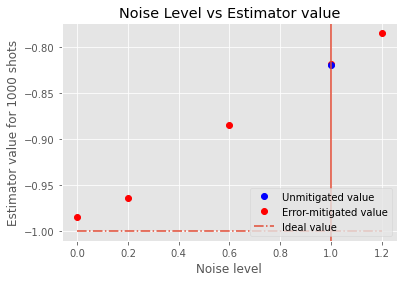

In [105]:
xrange = np.linspace(0, max(lmbdas), 100)
mv, = plt.plot(lmbdas, mitigated_values, 'ro')
umv, = plt.plot([1], unmitigated_value, 'bo')
iv, = plt.plot(xrange, [-1]*len(xrange), '-.')
plt.xlabel("Noise level")
plt.ylabel("Estimator value for %s shots" %samples)
plt.axvline(1)
plt.title("Noise Level vs Estimator value")
plt.legend([umv, mv, iv], ['Unmitigated value', 'Error-mitigated value', 'Ideal value'], loc="lower right")